# ECE 157A/272A Fall 2024 Homework 2

Name: Yiguang Zhu

In [1]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-Learn Descision Tree and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

### Helper Functions

In [2]:
# TODO: Implement a function that takes a wafer map and outputs it to a directory with the given name
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
    # use os library to check whether directory exists
    # if not, make the directory
    # CODE HERE
    if not os.path.exists(dir):
        os.makedirs(dir)


    # use plt.imsave to save wafer_map under the given directory with the given name
    # note: set the min value (vmin) and max vlaue (vmax) for plt.imsave based on wafer map value range
    # CODE HERE
    plt.imsave(os.path.join(dir, f"{name}.png"), wafer_map, vmin=vmin, vmax=vmax, cmap="viridis")



# TODO: Implement a function that outputs all wafer maps to corresponding failure type directories
def output_all_wafer_maps(df: pd.DataFrame) -> None:
    # iterate through all rows in the dataframe with df.iterrows()
    # CODE HERE
        # From the row, get wafer map, failure type, lot name and wafer index
        # output wafer map as "<failure type dir>/<lot name>-<wafer index>.png"
        # CODE HERE
    for _, row in df.iterrows():
        # Extract data from the row
        wafer_map = row['waferMap']
        failure_type = row['failureType']
        lot_name = row['lotName']
        wafer_index = row['waferIndex']

        # Define directory and filename
        directory = os.path.join('wafer_maps', failure_type)
        filename = f"{lot_name}-{wafer_index}"

        # Save wafer map image
        output_image(wafer_map, filename, directory)


In [3]:
# TODO: Implement a function that generate a single plot showing one wafer map example from each failure type
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9), index_off: int = 0) -> None:
    # Find unique failure types within the "failureType" column of the df
    # CODE HERE
    failure_types = df['failureType'].unique()

    # Create plt canvas with 6 subplots (2 rows and 3 columns) with plt.subplots
    # CODE HERE
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    # iterate through all the classes and show one wafer map per class
    # CODE HERE
    for i, failure_type in enumerate(failure_types):
        # Pick the first image from each category
        # hint: search for select pandas row based on conditions
        # and dataframe indexing
        # CODE HERE
        wafer_map = df[df['failureType'] == failure_type].iloc[index_off]['waferMap']
        # Plt image on the axes
        # CODE HERE
        axes[i].imshow(wafer_map, vmin=0, vmax=2, cmap='viridis')
        axes[i].set_title(failure_type)

    # show your plot
    plt.show()


### Load Dataset

In [5]:
# load training dataset as pandas dataframe
np_train = np.load('wafermap_train.npy', allow_pickle=True)
df_train = pd.DataFrame.from_records(np_train)


### Inspect Dataset

In [6]:
# use pandas to inspect the dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dieSize         2746 non-null   float64
 1   failureType     2746 non-null   object 
 2   lotName         2746 non-null   object 
 3   trainTestLabel  2746 non-null   object 
 4   waferIndex      2746 non-null   float64
 5   waferMap        2746 non-null   object 
dtypes: float64(2), object(4)
memory usage: 128.8+ KB


In [7]:
# inspect the dieSize
# notice that the die size varies?
# We will need to preprocess them to make it uniform
df_train['dieSize'].value_counts()

,count
dieSize,
1334.0,300
1226.0,191
1801.0,177
1080.0,176
2393.0,129
...,...
1153.0,1
3858.0,1
6547.0,1


<Axes: >

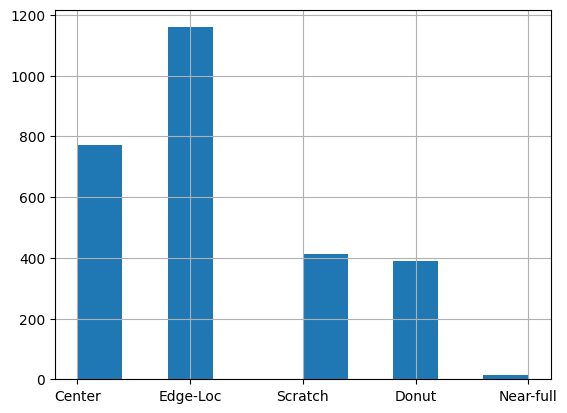

In [8]:
# inspect the failure types and the distributions
df_train['failureType'].hist()

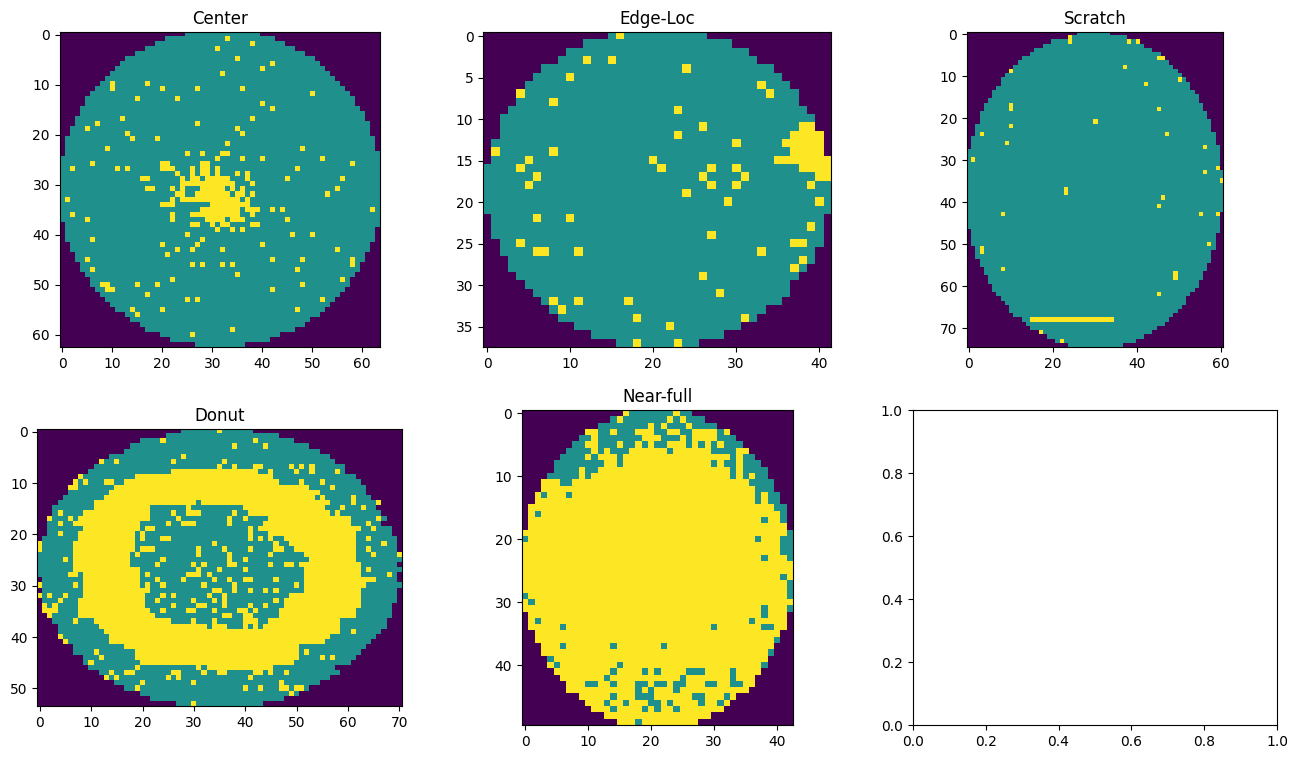

In [9]:
# show a wafermap in each class
visualize_failure_types(df_train)

In [10]:
# output all images to failure type directory
root_dir = 'defect_types'
output_all_wafer_maps(df_train)

### Data Preparation (Part 1)

For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [11]:
#Create dictionary for converting string to numeric number
import cv2
string2int = {
    "Center": 0,
    "Edge-Loc": 1,
    "Scratch": 2,
    "Donut": 3,
    "Near-full": 4
}
# TODO: The function takes the failure type string
# and returns the numeric value of failureType
# Make use of your dictionary from the line above.
def convert_failure_type(failure_type: str) -> int:
    return string2int.get(failure_type, -1)

# TODO: The function resizes a wafer to specified output shape using opencv's resize function
def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple = (64, 64)) -> np.ndarray:
    return cv2.resize(wafer_map, output_shape, interpolation=cv2.INTER_NEAREST)

# create dataframe columns to store the return values of the two tasks below:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64),
#       (2) and converts the failureType into numeric values
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:
    # Resize_wafer_map function to resize the wafer map to a larger size
    # note: here we decided to overwrite the waferMap column, but for best
    # practice, it's best to create a new column unless you don't need the original
    # wafer map data anymore
    df['waferMap'] = df['waferMap'].apply(resize_wafer_map)
    if(has_labels):
        df['failureTypeInt'] = df['failureType'].apply(convert_failure_type)

    return df

Prepare the data with the above function

In [12]:
# actually resizing the wafer map and converting failure types
# in the training dataframe
df_train = prepare_data(df_train)

### Feature Engineering
Extract features from the wafer maps

In [13]:
# The function that detects connect components using skimage
# and selects one with the largest area which we call salient region
# TODO: skip to the create_feature_columns code block and generate salient region
# before proceeding to other feature extractor functions
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
from skimage.measure import perimeter, label, regionprops
from skimage.morphology import convex_hull_image
import numpy as np
FAIL = 2  # Failing dice
NO_DIE = 0  # No dice
def get_salient_region(row: pd.Series) -> np.ndarray:
    # get wafer map from dataframe row
    wafer_map = row['waferMap']

    # create a wafer map with NO_DIE as background and FAIL as defect
    failure_only = np.zeros_like(wafer_map)
    failure_only[wafer_map==FAIL] = 1

    # label the connected components and get their regions properties
    # note: you might want to plot the labeled_image to take a look at the
    # return of the label function
    labeled_image = label(failure_only, background=NO_DIE, connectivity=2)
    region_props = regionprops(labeled_image)

    # returns the largest connected component as salient region
    # note: label image starts connected component label at value 1 with background being 0
    # thus, we need to add 1 after argmax
    largest_region_label = np.argmax([prop.area for prop in region_props]) + 1
    salient_region = (labeled_image == largest_region_label).astype(int)

    # # uncomment to verify the salient region
    #fig, ax = plt.subplots(nrows=1, ncols=2)
    #ax[0].imshow(wafer_map)
    #ax[1].imshow(salient_region)
    #plt.show()

    return salient_region

# TODO: The function returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE

    # count the number of fail dice on salient region
    # count the total number of dice on wafer map
    # divide them to get area_ratio
    # CODE HERE
    salient_region = get_salient_region(row)
    total_area = np.count_nonzero(row['waferMap'])
    salient_area = np.count_nonzero(salient_region)
    area_ratio = salient_area / total_area if total_area > 0 else 0
    return area_ratio

# TODO: The function returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties
    # CODE HERE
    perimeter_val = perimeter(salient_region)
    # find perimeter and wafer map radius
    # CODE HERE
    wafer_area = np.count_nonzero(row['waferMap'])
    radius = np.sqrt(wafer_area / np.pi)
    # divide them to get ratio
    # CODE HERE
    perimeter_ratio = perimeter_val / radius if radius > 0 else 0
    return perimeter_ratio
# TODO: The function returns the maximal distance between the salient region and
# the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    salient_region = get_salient_region(row)


    # find center of the wafer map
    # CODE HERE
    center = np.array(row['waferMap'].shape) / 2

    # get all coordinates of the salient region and compute the max distance
    # from center
    # CODE HERE
    coords = np.column_stack(np.nonzero(salient_region))
    max_dist = np.max(np.linalg.norm(coords - center, axis=1))
    return max_dist


# TODO: The function returns the minimal distance between the salient region and
# the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    salient_region = get_salient_region(row)

    # find center of the wafer map
    # CODE HERE
    center = np.array(row['waferMap'].shape) / 2


    # get all coordinates of the salient region and compute the min distance
    # from center
    # CODE HERE

    coords = np.column_stack(np.nonzero(salient_region))
    min_dist = np.min(np.linalg.norm(coords - center, axis=1))
    return min_dist
# TODO: The function returns the ratio of the length of the major axis of the estimated
# ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties
    # CODE HERE
    props = regionprops(label(salient_region))[0]
    # find major axis and wafer map radius
    # CODE HERE
    radius = np.sqrt(np.count_nonzero(row['waferMap']) / np.pi)
    major_axis_ratio = props.major_axis_length / (2 * radius) if radius > 0 else 0
    return major_axis_ratio

# TODO: The function returns the ratio of the length of the minor axis of the estimated
# ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE
    salient_region = get_salient_region(row)

    # label the salient region connected components and get their regions properties
    # CODE HERE
    props = regionprops(label(salient_region))[0]

    # find minor axis and wafer map radius
    # CODE HERE
    radius = np.sqrt(np.count_nonzero(row['waferMap']) / np.pi)
    minor_axis_ratio = props.minor_axis_length / (2 * radius) if radius > 0 else 0
    return minor_axis_ratio


#TODO: The function returns the solidity, indicating the proportion of defective dice
# in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE

    # label the salient region connected components and get their regions properties
    # CODE HERE

    # get solidity of salient region
    # CODE HERE

    salient_region = get_salient_region(row)
    props = regionprops(label(salient_region))[0]
    return props.solidity
# TODO: The function returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    # CODE HERE

    # label the salient region connected components and get their regions properties
    # CODE HERE

    # get eccentricity of salient region
    # CODE HERE

    salient_region = get_salient_region(row)
    props = regionprops(label(salient_region))[0]
    return props.eccentricity
# TODO: The function returns the ratio of the failed dice on the wafer map to the total
# number of dice on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    # CODE HERE

    # count FAIL dice and total number of dice
    # CODE HERE

    # compute yield loss
    # CODE HERE

    wafer_map = row['waferMap']
    total_dice = np.count_nonzero(wafer_map > 0)
    failed_dice = np.count_nonzero(wafer_map == FAIL)
    yield_loss = failed_dice / total_dice if total_dice > 0 else 0
    return yield_loss
# TODO: The function returns the ratio of the failed dice on the outermost two rings of the
# wafer map to the total number of dice on the outermost two rings of the wafer map
def get_edge_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    # CODE HERE

    # find ring label that highlights the outermost two rings of the wafer
    # CODE HERE

    # get edge FAIL dice and total number of edge dice
    # CODE HERE

    wafer_map = row['waferMap']
    edge_mask = ring_label_from_outside(wafer_map)
    edge_dice = wafer_map[edge_mask > 0]
    edge_fail_dice = np.count_nonzero(edge_dice == FAIL)
    total_edge_dice = np.count_nonzero(edge_dice > 0)
    edge_yield_loss = edge_fail_dice / total_edge_dice if total_edge_dice > 0 else 0
    return edge_yield_loss

# TODO: This helper function returns return an numpy array highlighting the outermost two rings
# of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    # CODE HERE
    mask = np.zeros_like(wafer_map)
    mask[1:-1, 1:-1] = 1
    outer_ring = wafer_map - mask
    outer_ring[outer_ring != 0] = 1
    return outer_ring


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.035736482287134864
13.0
0.0
2.308077326088
0.2991343500405017
0.17123424330839998
0.5665024630541872
0.819951802481801
0.07178371659415786
0.8133802816901409


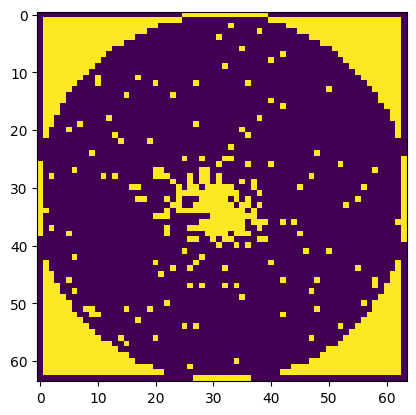

In [14]:
# # uncomment to use test codes for feature extractor functions
failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]

print(get_salient_region(row))
print(get_area_ratio(row))
print(get_max_dist_from_center(row))
print(get_min_dist_from_center(row))
print(get_perimeter_ratio(row))
print(get_major_axis_ratio(row))
print(get_minor_axis_ratio(row))
print(get_solidity(row))
print(get_eccentricity(row))
print(get_yield_loss(row))
print(get_edge_yield_loss(row))

plt.imshow(ring_label_from_outside(row['waferMap']))


In [15]:
# This function applies all feature extractor functions onto the
# dataframe and save the results to new columns
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:
    # format df['<new column name>'] = df.apply(<feature extractor function>, axis=1)
    df['salientRegion'] = df.apply(get_salient_region, axis=1)
    # TODO: fill in the rest of the feature extractor functions using same format
    # CODE HERE
    df['salientRegion'] = df.apply(get_salient_region, axis=1)
    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    # Return the updated dataframe df at the end.
    # CODE HERE
    return df


In [16]:
# actually applying the feature extractors on the training dataframe
df_train = create_feature_columns(df_train)

### Data Preparation (Part 2)

prepare the dataset for training models

In [17]:
# TODO: From the dataframe select the features we extracted as X
# and y is the numerical failure type labels
# CODE HERE
X = df_train[['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter',
        'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
        'yieldLoss', 'edgeYieldLoss']]
y = df_train['failureTypeInt']
# TODO: split dataset into training and validation set
# we will set aside some portion of the training data as validation data
X_train, X_valid, y_train, y_valid = train_test_split(
   X, y, test_size=0.2, random_state=42 # CODE HERE
)

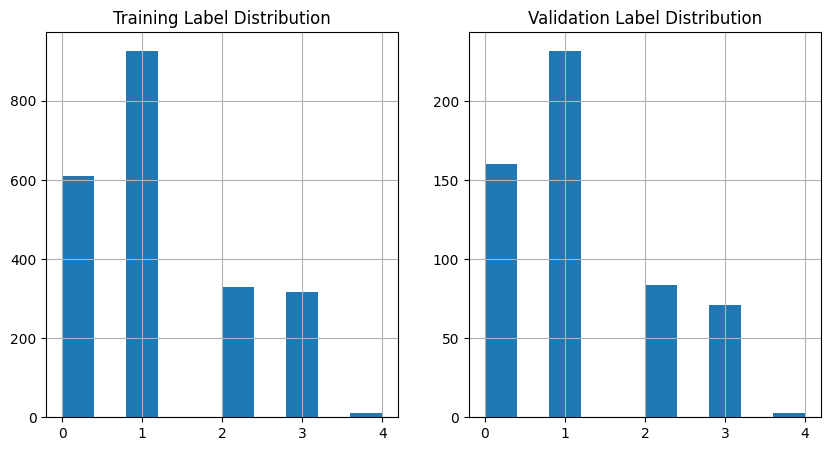

In [18]:
# check train/validation distribution
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
y_train.hist()
plt.title('Training Label Distribution')

plt.subplot(1,2,2)
y_valid.hist()
plt.title('Validation Label Distribution')

plt.show()

Train and Evaluate a Decision Tree Model

In [31]:
# TODO: initialize Decision Tree classifier with max tree depth of 3
# CODE HERE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

clf = DecisionTreeClassifier(max_depth=3, random_state=42)

clf_svc = SVC(random_state=42)

# TODO: Train the Decision Tree classifier with the training data
# CODE HERE
clf.fit(X_train, y_train)
clf_svc.fit(X_train, y_train)


SVC(random_state=42)

In [32]:
# TODO: Make a dictionary that is the reverse of the string2int mapping
# defined above. You can do this by hand, or for added challenge figure
# out how to do it programmatically so that the two remain in sync.
int2String = {
v: k for k, v in string2int.items()
}

# TODO: Implement a function that calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    correct_predictions = np.sum(pred_labels == true_labels)
    total_predictions = len(true_labels)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy


# TODO: Implement a function that calculates the prediction accuracy for each failure type separately.
def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    unique_classes = np.unique(true_labels)
    per_class_accuracy = {}

    for class_label in unique_classes:
        # Extract the indices of the current class
        class_indices = (true_labels == class_label)

        # Calculate accuracy for the current class
        correct_predictions = np.sum(pred_labels[class_indices] == true_labels[class_indices])
        total_predictions = np.sum(class_indices)

        # Store accuracy for the class
        per_class_accuracy[int2String[class_label]] = correct_predictions / total_predictions if total_predictions > 0 else 0

    return per_class_accuracy



Model accuracy on training data set is 89.21%
Model accuracy on training data set for each class is {'Center': 0.9705400981996727, 'Edge-Loc': 0.9439050701186623, 'Scratch': 0.7720364741641338, 'Donut': 0.7097791798107256, 'Near-full': 1.0}


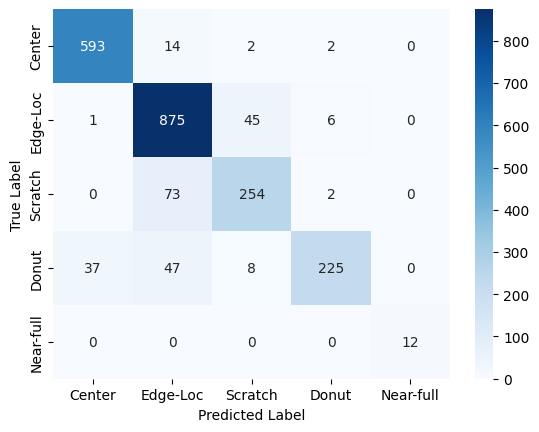

In [33]:
# TODO: get the predicted labels of the training data and calculate the accuracy
pred_train = (
clf.predict(X_train))
acc_train = (
calculate_accuracy(pred_train, y_train) * 100)
print(f'Model accuracy on training data set is {acc_train:.2f}%')

# TODO: calculate the accuracy for each failure type
accuracies_train = (
calculate_per_class_accuracy(pred_train, y_train))
print(f'Model accuracy on training data set for each class is {accuracies_train}')

# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints
# assigned to them.
tick_labels = [
int2String[i] for i in sorted(int2String.keys())]

# TODO: compute the confusion matrix
from sklearn.metrics import confusion_matrix
cm = (
confusion_matrix(y_train, pred_train)
)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=tick_labels ,
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis labels
# (Hint: Which is true? Which is predicted?)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# show plot
plt.show()

Model accuracy on validation data set is 89.09%
Model accuracy on validation data set for each class is {'Center': 0.975, 'Edge-Loc': 0.9439655172413793, 'Scratch': 0.7261904761904762, 'Donut': 0.7183098591549296, 'Near-full': 1.0}%


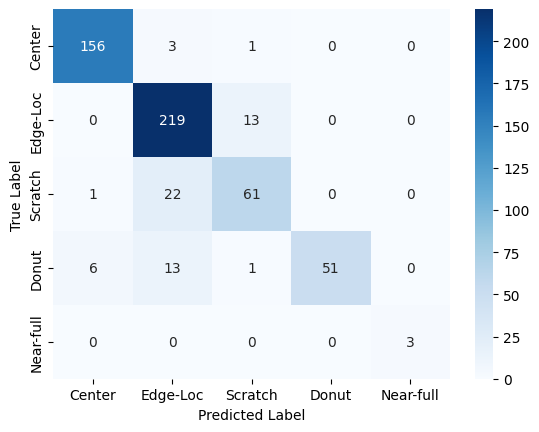

In [34]:
# TODO: get the predicted labels of the validation data and calculate the accuracy
# CODE HERE
pred_valid = clf.predict(X_valid)
acc_valid = calculate_accuracy(pred_valid, y_valid) * 100
print(f'Model accuracy on validation data set is {acc_valid:.2f}%')

# TODO: calculate the accuracy for each failure type
# CODE HERE
accuracies_valid = calculate_per_class_accuracy(pred_valid, y_valid)
print(f'Model accuracy on validation data set for each class is {accuracies_valid}%')

# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints
# assigned to them.
tick_labels = [
int2String[i] for i in sorted(int2String.keys())]
# TODO: compute confusion matrix
cm = (
confusion_matrix(y_valid, pred_valid)
)

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            cmap='Blues')

# TODO: provide x-axis label and y-axis label
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# show plot
plt.show()

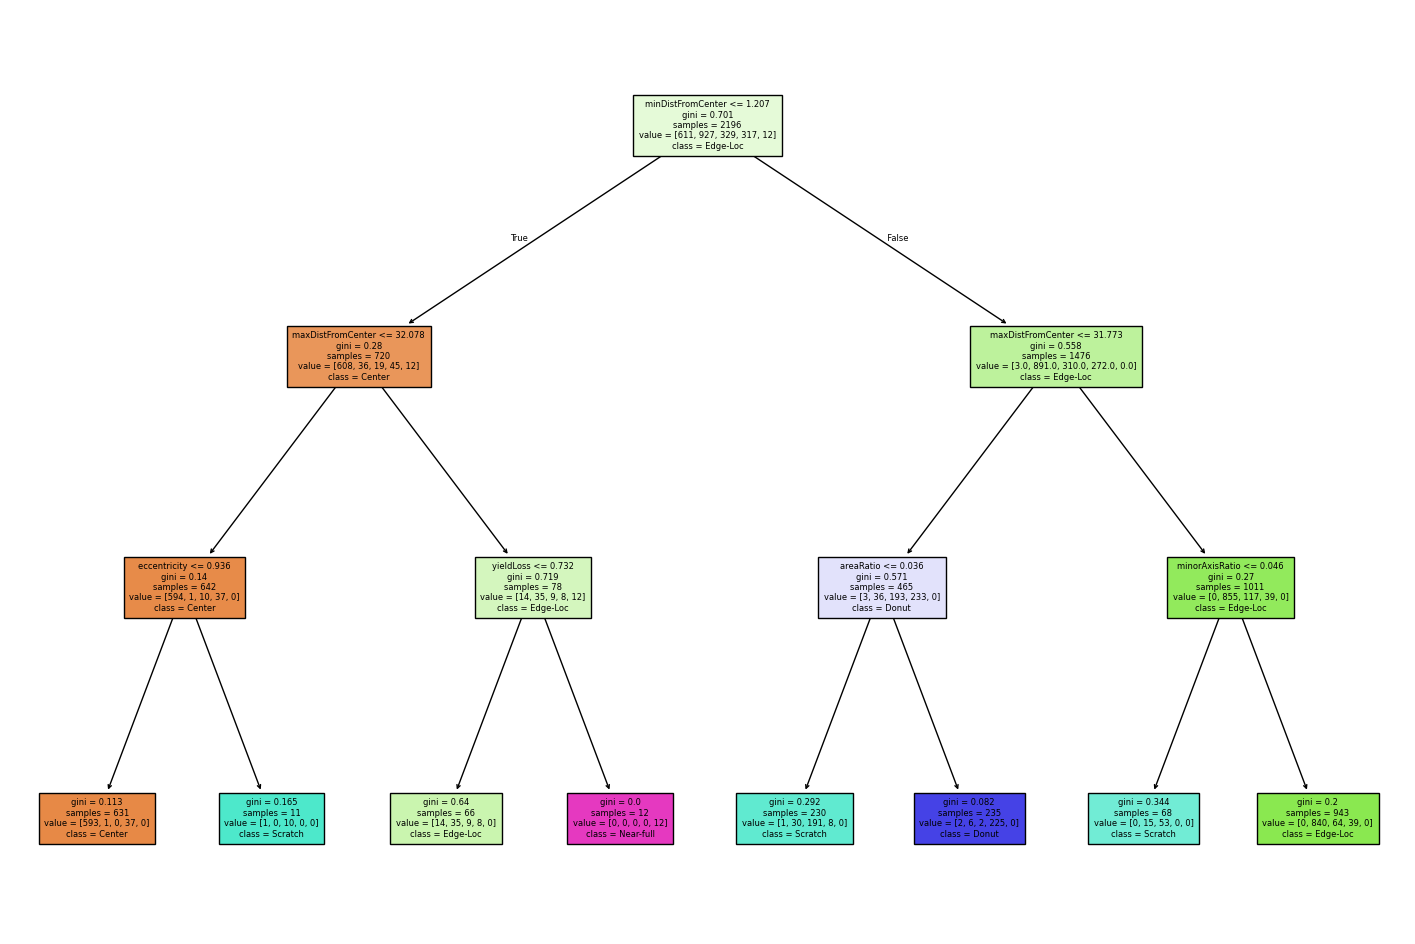

In [35]:
# TODO: get failure types string sorted by their numerical value
# that is, the strings like 'Center' and 'Scratch' sorted by the ints
# assigned to them.
tick_labels = [
int2String[i] for i in sorted(int2String.keys())]
selected_features = X.columns.tolist()

# plot decision tree
if isinstance(clf, tree.DecisionTreeClassifier):
    plt.figure(figsize=(18,12))
    tree.plot_tree(
        clf,                     # classifier to extract the rules from
        feature_names=selected_features,# the feature names that were used
        class_names=tick_labels,        # the class labels, converted to string
        filled=True, fontsize=6
    )
    plt.show()

### Testing Set

Data Loading, Preprocess, and Feature Extraction

In [36]:
# TODO: load test dataset with pandas from wafermap_test.npy
# CODE HERE
import pandas as pd
import numpy as np
test_data = np.load('wafermap_test.npy', allow_pickle=True)
df_test = pd.DataFrame.from_records(test_data)
# TODO: apply data preparation function
# note: test data does not have failureType column
# CODE HERE
df_test_prepared = prepare_data(df_test, has_labels=False)
# TODO: apply feature exatractors to extract features
# CODE HERE
df_test_prepared['areaRatio'] = df_test_prepared.apply(get_area_ratio, axis=1)
df_test_prepared['perimeterRatio'] = df_test_prepared.apply(get_perimeter_ratio, axis=1)
df_test_prepared['maxDistFromCenter'] = df_test_prepared.apply(get_max_dist_from_center, axis=1)
df_test_prepared['minDistFromCenter'] = df_test_prepared.apply(get_min_dist_from_center, axis=1)
df_test_prepared['majorAxisRatio'] = df_test_prepared.apply(get_major_axis_ratio, axis=1)
df_test_prepared['minorAxisRatio'] = df_test_prepared.apply(get_minor_axis_ratio, axis=1)
df_test_prepared['solidity'] = df_test_prepared.apply(get_solidity, axis=1)
df_test_prepared['eccentricity'] = df_test_prepared.apply(get_eccentricity, axis=1)
df_test_prepared['yieldLoss'] = df_test_prepared.apply(get_yield_loss, axis=1)
df_test_prepared['edgeYieldLoss'] = df_test_prepared.apply(get_edge_yield_loss, axis=1)
X_test = df_test_prepared[['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter',
                           'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
                           'yieldLoss', 'edgeYieldLoss']]

Generate Predictions for the Test Set

In [37]:
# TODO: From the dataframe select the features we extracted as X
# and y is the numerical failure type labels
# CODE HERE
X = df_test_prepared[['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter',
                      'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
                      'yieldLoss', 'edgeYieldLoss']]
# TODO: get the predicted labels of the test data,
# convert them back to strings,
# and output as `scores.csv`.
# CODE HERE
pred_test = clf.predict(X)
pred_test_labels = [int2String[label] for label in pred_test]
output_df = pd.DataFrame({'PredictedFailureType': pred_test_labels})
output_df.to_csv('scores.csv', index=False)

In [39]:
# Decision Tree predictions
pred_dt = clf.predict(X_test)
pred_dt_labels = [int2String[label] for label in pred_dt]  # Convert to string labels
output_dt = pd.DataFrame({'PredictedFailureType': pred_dt_labels})
output_dt.to_csv('dt_scores.csv', index=False)  # Save as dt_scores.csv


# Support Vector Classifier predictions
pred_svc = clf_svc.predict(X_test)
pred_svc_labels = [int2String[label] for label in pred_svc]  # Convert to string labels
output_svc = pd.DataFrame({'PredictedFailureType': pred_svc_labels})
output_svc.to_csv('svc_scores.csv', index=False)  # Save as svc_scores.csv